__Import Libraries__

In [2]:
from typing import Dict, Tuple
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader


import torchvision.transforms as transforms 
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
from torch.utils.data import Dataset

import numpy as np
import pathlib 
import matplotlib.pyplot as plt 
import os 
from PIL import Image

# Not show warnings 
import warnings 
warnings.filterwarnings("ignore")

__Step 1: Prepare the Dataset__

In [3]:
!gdown 1uS83j2T39p1iCD4K4KIeR8KiVDXGpreB

Downloading...
From: https://drive.google.com/uc?id=1uS83j2T39p1iCD4K4KIeR8KiVDXGpreB
To: /content/Task_1.zip
100% 146M/146M [00:05<00:00, 25.8MB/s]


In [9]:
from zipfile import ZipFile
file_name = '/content/Task_1.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


Click _Refresh_ in the colab _File_ section.

In [10]:
cd /content/Task_1

/content/Task_1


`pathlib` library to generate a list of image files:

In [11]:
imgdir_path = pathlib.Path('flowers_img')
file_list = sorted([str(path) for path in imgdir_path.glob('*.jpg')])
print(file_list[:3])

['flowers_img/image_00001.jpg', 'flowers_img/image_00002.jpg', 'flowers_img/image_00003.jpg']


Let's visualize the first ten images using Matplotlib

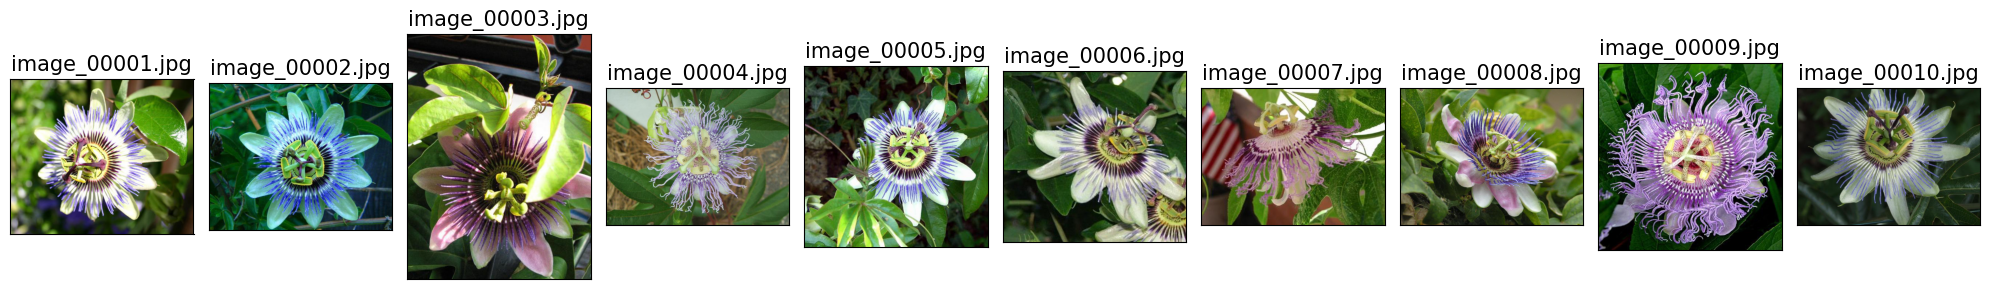

In [12]:
fig = plt.figure(figsize = (20, 18))
for i, file in enumerate(file_list[:10]):
  img = Image.open(file)
  ax = fig.add_subplot(1, 10, i+1)
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(img)
  ax.set_title(os.path.basename(file), size=15)

plt.tight_layout()
plt.show()


Let's apply following transformations to this dataset: 
- resize to a size of 64 $\times$ 64
- convert to tensors
- normalize 

In [13]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [14]:
class FlowersDataset(Dataset):
  def __init__(self, file_list, transform = None):
    self.file_list = file_list 
    self.transform = transform # function 
  
  def __getitem__(self, index):
    img = Image.open(self.file_list[index])
    if self.transform is not None:
      img = self.transform(img)
    return img
  
  def __len__(self):
    return len(self.file_list)

In [15]:
flowers_dataset = FlowersDataset(file_list, transform)

Again, lets visulize the first ten images from the dataset:

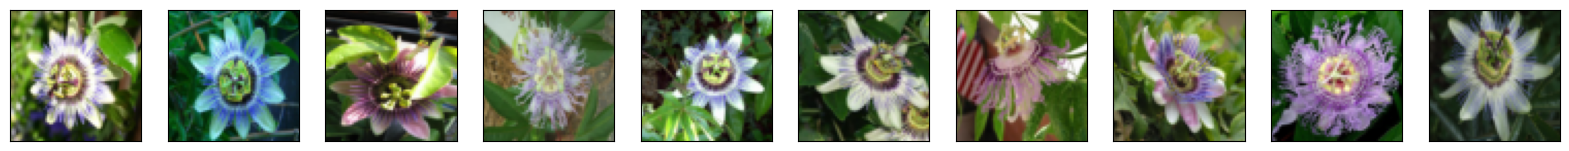

In [16]:
from itertools import islice 
fig = plt.figure(figsize = (20, 18))
for i, image in islice(enumerate(flowers_dataset), 10):
  image = image / 2 + 0.5 # unnormalize
  ax = fig.add_subplot(1, 10, i+1)
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(image.numpy().transpose((1, 2, 0)))
plt.show()

Next, lets define the dataloader with batches of 32 images for the training set of size 2230 images

In [ ]:
#######################################
batch_size = 32
torch.manual_seed(1)

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

flowers_dataset = FlowersDataset(file_list, transform)


train_loader = DataLoader(flowers_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
print('Train size', len(flowers_dataset))

Train size 2230


Lets plot 10 random images from the dataset:

In [ ]:
def plot_random_images(loader):

    images_batch = next(iter(loader))
    fig = plt.figure(figsize=(20, 18))

    for j in range(10):
      img = images_batch[j]  
      img = img / 2 + 0.5 # unnormalize
      ax = fig.add_subplot(1, 10, j + 1)
      ax.set_xticks([])
      ax.set_yticks([])
      ax.imshow(img.permute(1, 2, 0))
      
    plt.show()

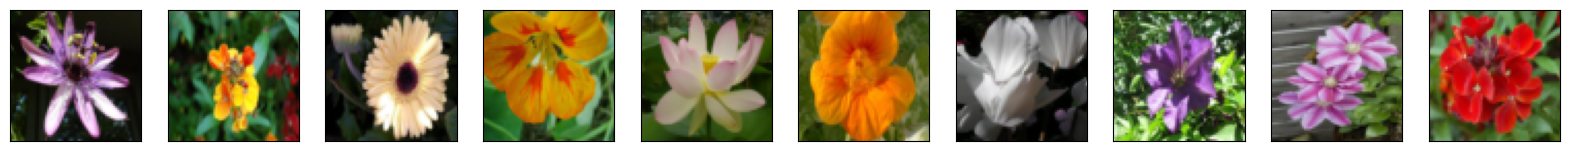

In [ ]:
plot_random_images(train_loader)

__Step 2: Training Procedure__

Now, we are ready to write the code for training `ddpm` model on our dataset

In [ ]:
 
from mindiffusion.unet import NaiveUnet
from mindiffusion.ddpm import DDPM

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# model
ddpm = DDPM(eps_model=NaiveUnet(3, 3, n_feat=128), betas=(1e-4, 0.02), n_T=1000)
ddpm.to(device)

# the optimizer 
optim = torch.optim.Adam(ddpm.parameters(), lr=1e-5)

# training procedure 
n_epoch = 100
for i in range(n_epoch):
    print(f"Epoch {i} : ")
    ddpm.train()

    pbar = tqdm(train_loader)
    loss_ema = None
    for x in pbar:
        optim.zero_grad()
        x = x.to(device)
        loss = ddpm(x)
        loss.backward()
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
        pbar.set_description(f"loss: {loss_ema:.4f}")
        optim.step()

    ddpm.eval()
    with torch.no_grad():
        xh = ddpm.sample(8, (3, 64, 64), device) # changed the image dimensions for out dataset 
        xset = torch.cat([xh, x[:8]], dim=0)
        grid = make_grid(xset, normalize=True, value_range=(-1, 1), nrow=4)
        save_image(grid, f"./flower_samples/ddpm_sample_flower{i}.png")

        # save model
        torch.save(ddpm.state_dict(), f"./ddpm_flower.pth")

Epoch 0 : 


loss: 0.7600: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s]


Epoch 1 : 


loss: 0.4584: 100%|██████████| 70/70 [00:27<00:00,  2.57it/s]


Epoch 2 : 


loss: 0.2777: 100%|██████████| 70/70 [00:26<00:00,  2.62it/s]


Epoch 3 : 


loss: 0.1992: 100%|██████████| 70/70 [00:26<00:00,  2.61it/s]


Epoch 4 : 


loss: 0.1486: 100%|██████████| 70/70 [00:27<00:00,  2.54it/s]


Epoch 5 : 


loss: 0.1358: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Epoch 6 : 


loss: 0.1204: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s]


Epoch 7 : 


loss: 0.1209: 100%|██████████| 70/70 [00:26<00:00,  2.64it/s]


Epoch 8 : 


loss: 0.1274: 100%|██████████| 70/70 [00:26<00:00,  2.59it/s]


Epoch 9 : 


loss: 0.1088: 100%|██████████| 70/70 [00:26<00:00,  2.63it/s]


Epoch 10 : 


loss: 0.0953: 100%|██████████| 70/70 [00:26<00:00,  2.64it/s]


Epoch 11 : 


loss: 0.1060: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s]


Epoch 12 : 


loss: 0.1005: 100%|██████████| 70/70 [00:27<00:00,  2.52it/s]


Epoch 13 : 


loss: 0.0849: 100%|██████████| 70/70 [00:26<00:00,  2.64it/s]


Epoch 14 : 


loss: 0.0881: 100%|██████████| 70/70 [00:26<00:00,  2.64it/s]


Epoch 15 : 


loss: 0.0840: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Epoch 16 : 


loss: 0.0838: 100%|██████████| 70/70 [00:26<00:00,  2.63it/s]


Epoch 17 : 


loss: 0.0761: 100%|██████████| 70/70 [00:26<00:00,  2.60it/s]


Epoch 18 : 


loss: 0.0824: 100%|██████████| 70/70 [00:26<00:00,  2.60it/s]


Epoch 19 : 


loss: 0.0814: 100%|██████████| 70/70 [00:26<00:00,  2.64it/s]


Epoch 20 : 


loss: 0.0777: 100%|██████████| 70/70 [00:26<00:00,  2.61it/s]


Epoch 21 : 


loss: 0.0668: 100%|██████████| 70/70 [00:25<00:00,  2.70it/s]


Epoch 22 : 


loss: 0.0806: 100%|██████████| 70/70 [00:26<00:00,  2.61it/s]


Epoch 23 : 


loss: 0.0754: 100%|██████████| 70/70 [00:27<00:00,  2.52it/s]


Epoch 24 : 


loss: 0.0726: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Epoch 25 : 


loss: 0.0707: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Epoch 26 : 


loss: 0.0741: 100%|██████████| 70/70 [00:26<00:00,  2.64it/s]


Epoch 27 : 


loss: 0.0698: 100%|██████████| 70/70 [00:26<00:00,  2.61it/s]


Epoch 28 : 


loss: 0.0683: 100%|██████████| 70/70 [00:26<00:00,  2.64it/s]


Epoch 29 : 


loss: 0.0649: 100%|██████████| 70/70 [00:26<00:00,  2.64it/s]


Epoch 30 : 


loss: 0.0676: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Epoch 31 : 


loss: 0.0651: 100%|██████████| 70/70 [00:26<00:00,  2.62it/s]


Epoch 32 : 


loss: 0.0643: 100%|██████████| 70/70 [00:26<00:00,  2.64it/s]


Epoch 33 : 


loss: 0.0555: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Epoch 34 : 


loss: 0.0620: 100%|██████████| 70/70 [00:27<00:00,  2.57it/s]


Epoch 35 : 


loss: 0.0654: 100%|██████████| 70/70 [00:26<00:00,  2.64it/s]


Epoch 36 : 


loss: 0.0663: 100%|██████████| 70/70 [00:26<00:00,  2.61it/s]


Epoch 37 : 


loss: 0.0566: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Epoch 38 : 


loss: 0.0560: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Epoch 39 : 


loss: 0.0627: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s]


Epoch 40 : 


loss: 0.0644: 100%|██████████| 70/70 [00:27<00:00,  2.59it/s]


Epoch 41 : 


loss: 0.0694: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Epoch 42 : 


loss: 0.0568: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Epoch 43 : 


loss: 0.0567: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Epoch 44 : 


loss: 0.0627: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s]


Epoch 45 : 


loss: 0.0614: 100%|██████████| 70/70 [00:27<00:00,  2.51it/s]


Epoch 46 : 


loss: 0.0565: 100%|██████████| 70/70 [00:26<00:00,  2.61it/s]


Epoch 47 : 


loss: 0.0574: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Epoch 48 : 


loss: 0.0638: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s]


Epoch 49 : 


loss: 0.0571: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s]


Epoch 50 : 


loss: 0.0578: 100%|██████████| 70/70 [00:26<00:00,  2.60it/s]


Epoch 51 : 


loss: 0.0506: 100%|██████████| 70/70 [00:26<00:00,  2.63it/s]


Epoch 52 : 


loss: 0.0565: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Epoch 53 : 


loss: 0.0525: 100%|██████████| 70/70 [00:25<00:00,  2.70it/s]


Epoch 54 : 


loss: 0.0589: 100%|██████████| 70/70 [00:26<00:00,  2.60it/s]


Epoch 55 : 


loss: 0.0568: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Epoch 56 : 


loss: 0.0486: 100%|██████████| 70/70 [00:27<00:00,  2.56it/s]


Epoch 57 : 


loss: 0.0527: 100%|██████████| 70/70 [00:26<00:00,  2.64it/s]


Epoch 58 : 


loss: 0.0539: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s]


Epoch 59 : 


loss: 0.0588: 100%|██████████| 70/70 [00:26<00:00,  2.63it/s]


Epoch 60 : 


loss: 0.0484: 100%|██████████| 70/70 [00:26<00:00,  2.60it/s]


Epoch 61 : 


loss: 0.0533: 100%|██████████| 70/70 [00:26<00:00,  2.63it/s]


Epoch 62 : 


loss: 0.0575: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s]


Epoch 63 : 


loss: 0.0535: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Epoch 64 : 


loss: 0.0523: 100%|██████████| 70/70 [00:26<00:00,  2.62it/s]


Epoch 65 : 


loss: 0.0536: 100%|██████████| 70/70 [00:26<00:00,  2.61it/s]


Epoch 66 : 


loss: 0.0554: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s]


Epoch 67 : 


loss: 0.0559: 100%|██████████| 70/70 [00:27<00:00,  2.57it/s]


Epoch 68 : 


loss: 0.0414: 100%|██████████| 70/70 [00:26<00:00,  2.68it/s]


Epoch 69 : 


loss: 0.0440: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s]


Epoch 70 : 


loss: 0.0464: 100%|██████████| 70/70 [00:27<00:00,  2.51it/s]


Epoch 71 : 


loss: 0.0423: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s]


Epoch 72 : 


loss: 0.0489: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s]


Epoch 73 : 


loss: 0.0546: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Epoch 74 : 


loss: 0.0458: 100%|██████████| 70/70 [00:26<00:00,  2.61it/s]


Epoch 75 : 


loss: 0.0556: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Epoch 76 : 


loss: 0.0427: 100%|██████████| 70/70 [00:26<00:00,  2.67it/s]


Epoch 77 : 


loss: 0.0525: 100%|██████████| 70/70 [00:26<00:00,  2.63it/s]


Epoch 78 : 


loss: 0.0508: 100%|██████████| 70/70 [00:27<00:00,  2.54it/s]


Epoch 79 : 


loss: 0.0479: 100%|██████████| 70/70 [00:27<00:00,  2.55it/s]


Epoch 80 : 


loss: 0.0496: 100%|██████████| 70/70 [00:26<00:00,  2.60it/s]


Epoch 81 : 


loss: 0.0403: 100%|██████████| 70/70 [00:28<00:00,  2.47it/s]


Epoch 82 : 


loss: 0.0525: 100%|██████████| 70/70 [00:26<00:00,  2.61it/s]


Epoch 83 : 


loss: 0.0506: 100%|██████████| 70/70 [00:27<00:00,  2.58it/s]


Epoch 84 : 


loss: 0.0537: 100%|██████████| 70/70 [00:27<00:00,  2.54it/s]


Epoch 85 : 


loss: 0.0444: 100%|██████████| 70/70 [00:26<00:00,  2.60it/s]


Epoch 86 : 


loss: 0.0431: 100%|██████████| 70/70 [00:26<00:00,  2.62it/s]


Epoch 87 : 


loss: 0.0422: 100%|██████████| 70/70 [00:26<00:00,  2.66it/s]


Epoch 88 : 


loss: 0.0440: 100%|██████████| 70/70 [00:26<00:00,  2.59it/s]


Epoch 89 : 


loss: 0.0419: 100%|██████████| 70/70 [00:26<00:00,  2.60it/s]


Epoch 90 : 


loss: 0.0494: 100%|██████████| 70/70 [00:26<00:00,  2.60it/s]


Epoch 91 : 


loss: 0.0429: 100%|██████████| 70/70 [00:26<00:00,  2.62it/s]


Epoch 92 : 


loss: 0.0452: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Epoch 93 : 


loss: 0.0443: 100%|██████████| 70/70 [00:26<00:00,  2.60it/s]


Epoch 94 : 


loss: 0.0477: 100%|██████████| 70/70 [00:27<00:00,  2.59it/s]


Epoch 95 : 


loss: 0.0551: 100%|██████████| 70/70 [00:26<00:00,  2.61it/s]


Epoch 96 : 


loss: 0.0384: 100%|██████████| 70/70 [00:26<00:00,  2.62it/s]


Epoch 97 : 


loss: 0.0426: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Epoch 98 : 


loss: 0.0458: 100%|██████████| 70/70 [00:26<00:00,  2.61it/s]


Epoch 99 : 


loss: 0.0433: 100%|██████████| 70/70 [00:27<00:00,  2.59it/s]


__Step 3: Generating the images with the trained diffusion model__




Lets check how `ddpm` model generates 10 images similar to our flowers dataset:

10 Images of flowers generated by diffusion model


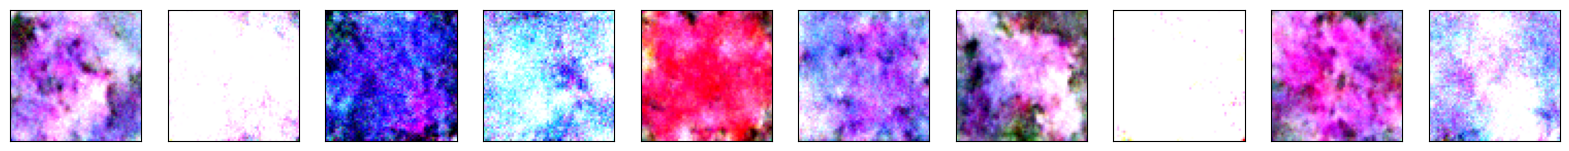

In [19]:
from mindiffusion.unet import NaiveUnet
from mindiffusion.ddpm import DDPM

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

PATH = f'ddpm_flower.pth'

model = DDPM(eps_model=NaiveUnet(3, 3, n_feat=128), betas=(1e-4, 0.02), n_T=1000)
model.to(device)

model.load_state_dict(torch.load(PATH))
model.eval()
with torch.no_grad():
    xh = model.sample(10, (3, 64, 64), device).cpu()

    fig = plt.figure(figsize=(20, 18))
    print("10 Images of flowers generated by diffusion model") 
    for j in range(10):
      img = xh[j]  
      img = img / 2 + 0.5 # unnormalize
      img = img.numpy()
      img = np.clip(img, 0, 1)
      ax = fig.add_subplot(1, 10, j + 1)
      ax.set_xticks([])
      ax.set_yticks([])
      ax.imshow((img.transpose(1, 2, 0)))
    plt.show()